# Features relations by mobility levels

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobility = load_od_baseline()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

Mobility Last Updated 05-08
Deaths Last Updated 05-26


In [4]:
od_mobility.shape

(3140, 4)

In [5]:
N_DAYS = 9
ONSET_THRESH = 3
GROWTH_THRESH = 0

In [6]:
# Get death dataframe date columns
death_dates = get_date_columns(deaths, return_dtimes=False)

In [7]:
def get_onset_date(row, thresh):
    above = row[row >= thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [8]:
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
deaths_df = deaths[['FIPS']+death_dates]

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_df)):
    county = deaths_df.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(death_dates)):
        if county[death_dates[j]] >= ONSET_THRESH:

            # See if this happened n_days or more before current day
            try:
                n_days_later = death_dates[j+N_DAYS]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break

In [9]:
## Normalize deaths by pop total
deaths_df = deaths[['FIPS']+death_dates]
deaths_df.dropna(subset=['FIPS'], inplace=True)
deaths_df = deaths_df.astype({'FIPS':int})

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row, thresh=ONSET_THRESH), axis=1)

## Drop counties with no onset
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

## Only counties with N_DAYS worth of data after onset
deaths_df = deaths_df[deaths_df['onset'].apply(
    lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= N_DAYS
)]

## Remove counties with significant growth decrease
deaths_df = deaths_df[
    deaths_df.apply(
        lambda r: r[[d for d in death_dates if 
            str2date(d) >= str2date(r['onset']) and 
            str2date(d) <= lag_date(str2date(r['onset']
        ), 
        lag=N_DAYS, backwards=False)]].diff().min() >= GROWTH_THRESH, axis=1
    )
]

## Get the cumulative deaths over the period
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: sum(r[[d for d in death_dates if 
        str2date(d) >= str2date(r['onset']) and 
        str2date(d) <= lag_date(str2date(r['onset']
    ), 
    lag=N_DAYS, backwards=False)]]), axis=1)

## Get the number of deaths at N_DAYS from onset
deaths_df['n_days_out'] = deaths_df.apply(
    lambda r: r[lag_date(str2date(r['onset']), lag=N_DAYS, backwards=False, return_date=False)], axis=1
)

In [17]:
cum_deaths = deaths_df[['FIPS', 'cum_deaths', 'n_days_out']]
cum_deaths = pd.merge(cum_deaths, hospitals, on='FIPS')

m50_dates = get_date_columns(m50, return_dtimes=False)
m50['baseline'] = m50.apply(lambda x: x[m50_dates[:7]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, m50[['FIPS', 'baseline']], on='FIPS')
cum_deaths.rename(columns={'baseline':'m50'}, inplace=True)
cum_deaths = pd.merge(cum_deaths, od_mobility, on='FIPS')

# confounder_dict = {
#     'POP_ESTIMATE_2018' : -1,
#     'Density per square mile of land area - Population': 0,
#     'Rural-urban_Continuum Code_2013': 0,
#     'Total_age65plus': 0,
# }
# cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + list(confounder_dict.keys())], on='FIPS')
# cum_deaths['normalized_deaths'] = cum_deaths.apply(
#     lambda row: normalize(row, confounder_dict), axis=1
#     )

# cum_deaths.dropna(axis=0, inplace=True)

In [18]:
static_features = counties[['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population', 'Percent of adults with less than a high school diploma 2014-18', 'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus', 'POP_ESTIMATE_2018']]
static_features = static_features.dropna()

cum_deaths = cum_deaths.merge(static_features, on="FIPS")

In [19]:
outliers = [36061, 6038, 17031, 48201]
cum_deaths = cum_deaths[~cum_deaths['FIPS'].isin(outliers)]

In [20]:
cum_deaths.head()

FIPS  cum_deaths  n_days_out  Beds  HospCt        m50  inter_movement  \
0  1003          30           3   332       3  11.690429   392719.831641   
1  1013          68           9    94       2  14.478143    35759.542287   
2  1015          30           3   552       3  10.211286   233595.308529   
3  1017          50           8   115       1  14.800857    57581.534069   
4  1047          30           3   175       1   7.734286    74313.935195   

     in_movement  out_movement  Rural-urban_Continuum Code_2013  \
0  107162.841211  81698.436421                              3.0   
1   11807.284984  11493.337366                              6.0   
2   69276.237684  51596.512414                              3.0   
3   18820.393859  27578.192994                              6.0   
4   13953.923591  16822.254490                              4.0   

   Density per square mile of land area - Population  \
0                                              114.6   
1                                               27.0   
2                                              195.7   
3                                               57.4   
4                                               44.8   

   Percent of adults with less than a high school diploma 2014-18  \
0                                                9.7                
1                                               15.4                
2                                               15.9                
3                                               18.6                
4                                               19.3                

   PCTPOV017_2018  Unemployment_rate_2018  Total_age65plus  POP_ESTIMATE_2018  
0            13.9                     3.6          44571.0             218022  
1            36.3                     4.8           3995.0              19680  
2            26.5                     4.7          20247.0             114277  
3            30.7                     3.9           6562.0              33615  
4            48.0                     6.5           6921.0              38310

In [21]:
log_cols = ['cum_deaths', 'n_days_out', 'HospCt', 'm50', 'Beds', 'inter_movement', 'in_movement', 'out_movement','Density per square mile of land area - Population','POP_ESTIMATE_2018']
cum_deaths[[lc + ' (log)' for lc in log_cols]] = cum_deaths[log_cols].transform('log')
cum_deaths['Beds (log)'] = (cum_deaths['Beds'] + 1).transform('log')

## Analyze df

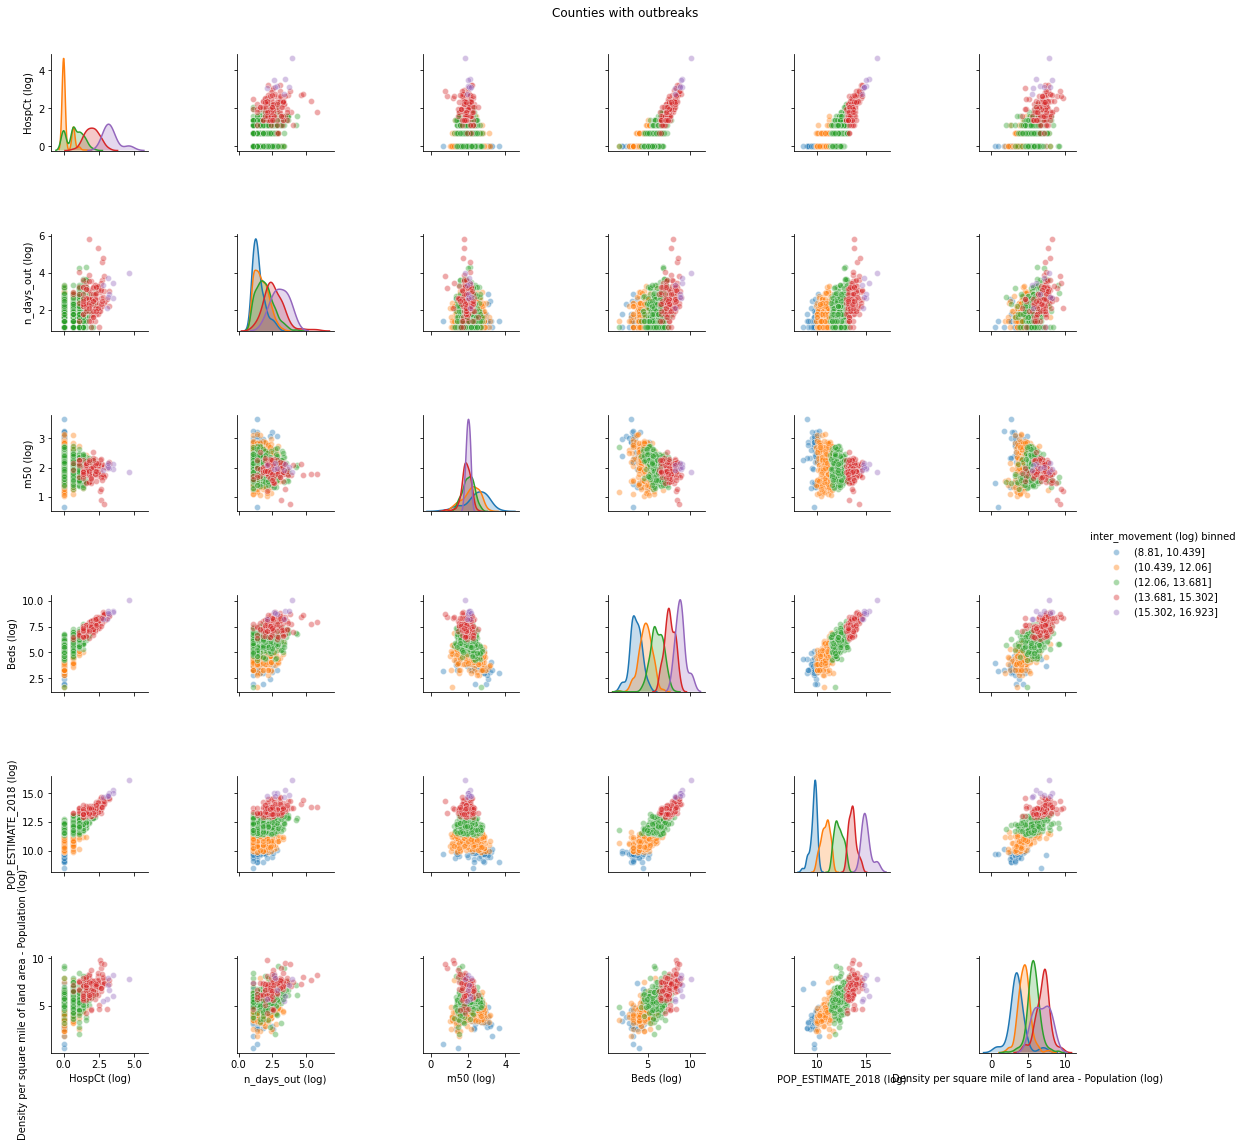

In [23]:
temp = cum_deaths#[cum_deaths['Rural-urban_Continuum Code_2013'].isin([3.0,4.0])]
cols = ['HospCt (log)',
        'n_days_out (log)',
        'm50 (log)',
        'Beds (log)',
        'POP_ESTIMATE_2018 (log)',
        'Density per square mile of land area - Population (log)'
]
hue = 'inter_movement (log)'

## cols to process, transform to apply
temp[hue + ' binned'] = pd.cut(temp[hue], bins=5)

fig = sns.pairplot(temp, vars=cols, hue=hue + ' binned', plot_kws={'alpha': 0.4})
fig.fig.suptitle('Counties with outbreaks', y=1.04)
plt.show()